## Notebook Overview

This notebook is inspired by [Denny Britz's Basic NN-Implementation](https://github.com/dennybritz/nn-from-scratch/blob/master/nn-from-scratch.ipynb). This is essentially me following along to his notebook, it is easier for me to understand a concept if I follow along the exercise step-by-step. 

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons

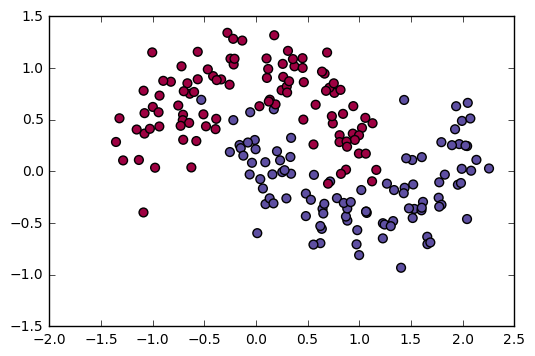

In [12]:
# A random seed for all numpy randomized operations
np.random.seed (0)

# Makes two interleaving half-circles based on the 
# gaussian distribution
X, y = make_moons (200, noise=0.20)

# Plot the data we generated
plt.scatter (X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show ()

## Logistic Regression

We will now attempt to classify our data using Logistic Regression. The important thing to note in this case, is that the data is not linearly separable thus our intention is to show the difficulty that linear regression will have in coming up with a satisfactory classifier.

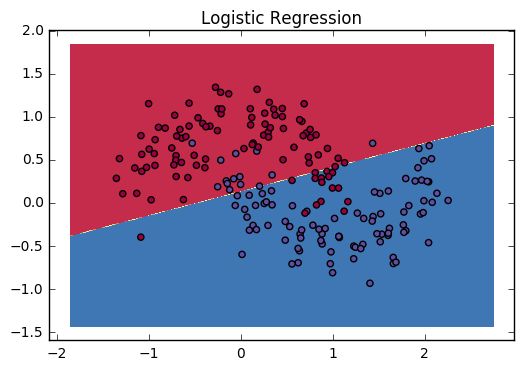

In [13]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV ()
clf.fit (X, y)

def plot_decision_boundary (prediction_function):
    # Set minimum and maximum values for the X and Y axis
    x_min, x_max = X[:,0].min () - 0.5, X[:,0].max () + 0.5
    y_min, y_max = X[:,1].min () - 0.5, X[:,1].max () + 0.5
    
    # Generate a grid of points with distance h between them
    h = 0.01
    xx, yy = np.meshgrid (np.arange (x_min, x_max, h), np.arange (y_min, y_max, h))
    
    # We predict the value of our function throughout the entire grid
    Z = prediction_function (np.c_[xx.ravel (), yy.ravel ()])
    Z = Z.reshape (xx.shape)
    
    # Plot the contour's (decision boundary) and training examples
    plt.contourf (xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter (X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)

plot_decision_boundary (lambda x: clf.predict (x))
plt.title("Logistic Regression")
plt.show ()

## Basic Neural Network

TODO RARS

In [14]:
# Get the number of examples in our training set
num_examples = len (X)

# Variables for input and output dimensions
nn_input_dim = 2
nn_output_dim = 2

# Regularization Parameters
reg_lambda = 0.01

In [16]:
def calculate_loss (model):
    W1, b1, W2, b2 = model["W1"], model["b1"], model["W2"], model["b2"]
    
    # Hidden layer calculations
    z1 = X.dot (W1) + b1
    # a1 = np.tanh (z1)
    a1 = 1./(1 + np.exp (-z1))
    
    # Output layer calculations
    z2 = a1.dot (W2) + b2
    
    # Manual implementation of Softmax
    exp_scores = np.exp (z2)
    probs = exp_scores / np.sum (exp_scores, axis=1, keepdims=True)
    
    # Now calculate the cross-entropy-loss
    correct_logprobs = -np.log (probs[range (num_examples), y])
    data_loss = np.sum (correct_logprobs)
    
    # Add regularization parameter
    data_loss += reg_lambda/2 * (np.sum (np.square (W1)) + np.sum (np.square (W2)))
    return 1./num_examples * data_loss

In [17]:
def predict (model, X):
    W1, b1, W2, b2 = model["W1"], model["b1"], model["W2"], model["b2"]
    
    # Do forward propagation, same as above
    z1 = X.dot (W1) + b1
    # a1 = np.tanh (z1)
    a1 = 1./(1 + np.exp (-z1))
    z2 = a1.dot (W2) + b2
    exp_scores = np.exp (z2)
    probs = exp_scores / np.sum (exp_scores, axis=1, keepdims=True)
    return np.argmax (probs, axis=1)

In [18]:
def build_model (nn_hdim, num_passes=20000, learning_rate = 0.01, stochastic=False, mini_batch=False, print_loss=False):
    # Initialize parameters to random values
    np.random.seed (43)
    # W1 is 2 x 500
    W1 = np.random.randn (nn_input_dim, nn_hdim) / np.sqrt (nn_input_dim)
    # b1 is 500
    b1 = np.zeros ((1, nn_hdim))
    # W2 is 500 x 2
    W2 = np.random.randn (nn_hdim, nn_output_dim) / np.sqrt (nn_hdim)
    # b2 is 2
    b2 = np.zeros ((1, nn_output_dim))
    
    model = {}
    
    for i in xrange (0, num_passes):
        #=======================Mini-Batch=======================#
        # Regular Gradient-Descent updates the parameters by doing
        # backpropagation on the entire dataset. Mini-Batch simply
        # samples from the training-set and updates based on that
        # sample. It is more computationally efficient to do so
        # and we get a good approximation of the gradient loss.
        if mini_batch:
            # Use 10% of the dataset as our batch_size
            batch_size = int (num_examples * 0.10)
            num_examples_batch = batch_size
            
            batch_idx = np.random.choice (len (X), batch_size, replace=False)
            X_batch = X[batch_idx]
            y_batch = y[batch_idx]
        #=======================Stochastic=======================#
        # Stochastic Gradient Descent is very similar to Mini-Batch
        # gradient descent, but in this case our batch size is 1
        elif stochastic:
            num_examples_batch = 1
            batch_idx = np.random.choice (len(X))
        else:
            # Treat the whole dataset as our batch
            num_examples_batch = num_examples
            X_batch = X
            y_batch = y
        
        #=======================Learning-Rate-Adaptation=======================#
        # Reduce the learning rate by half every 20 iterations, there are other
        # methods for doing this such as exponential decay or 1/t decay.
        # http://cs231n.github.io/neural-networks-3/#anneal
        if i+1 % 20 == 0:
            # We need to be careful, it is possible that our learning rate
            # goes down to zero. Here, we just keep the current learning rate
            # if that happens.
            if learning_rate / 2 == 0:
                pass
            else:
                learning_rate /= 2
        #=======================Learning-Rate-Adaptation=======================#
        
        # Forward propagation
        z1 = X.dot (W1) + b1
        # a1 = np.tanh (z1)
        a1 = 1./(1 + np.exp (-z1))
        z2 = a1.dot (W2) + b2
        exp_scores = np.exp (z2)
        probs = exp_scores / np.sum (exp_scores, axis=1, keepdims=True)
        
        # Backpropagation
        # Backprop on the softmax function
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot (delta3)
        db2 = np.sum (delta3, axis=0, keepdims=True)
        # delta2 = delta3.dot (W2.T) * (1 - np.power (a1,2))
        delta2 = delta3.dot (W2.T) * ((1 - a1) * a1)
        dW1 = np.dot (X.T, delta2)
        db1 = np.sum (delta2, axis=0)
        
        # Calculate regularization 
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
        
        # Gradient descent simultaneous update
        W1 += -learning_rate * dW1
        b1 += -learning_rate * db1
        W2 += -learning_rate * dW2
        b2 += -learning_rate * db2
        
        # Update Model
        model = {"W1" : W1, "b1" : b1, "W2" : W2, "b2" : b2}
        
        if print_loss and i % 1000 == 0:
            print "Loss after iteration %d : %f" % (i, calculate_loss (model))
            
    return model

Loss after iteration 0 : 0.587176
Loss after iteration 1000 : 0.302747
Loss after iteration 2000 : 0.301831
Loss after iteration 3000 : 0.295732
Loss after iteration 4000 : 0.082529
Loss after iteration 5000 : 0.079013
Loss after iteration 6000 : 0.078470
Loss after iteration 7000 : 0.078291
Loss after iteration 8000 : 0.078220
Loss after iteration 9000 : 0.078189
Loss after iteration 10000 : 0.078174
Loss after iteration 11000 : 0.078166
Loss after iteration 12000 : 0.078162
Loss after iteration 13000 : 0.078160
Loss after iteration 14000 : 0.078158
Loss after iteration 15000 : 0.078157
Loss after iteration 16000 : 0.078157
Loss after iteration 17000 : 0.078156
Loss after iteration 18000 : 0.078156
Loss after iteration 19000 : 0.078156


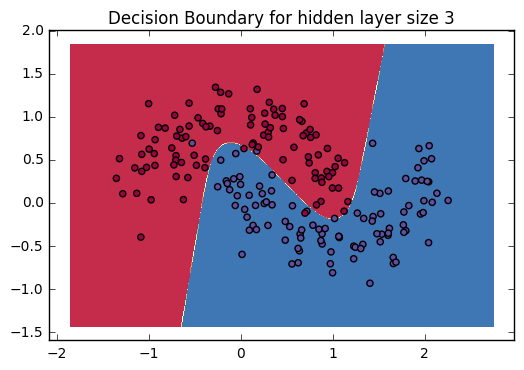

In [19]:
model = build_model (3, print_loss=True, mini_batch=True)

plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")
plt.show ()

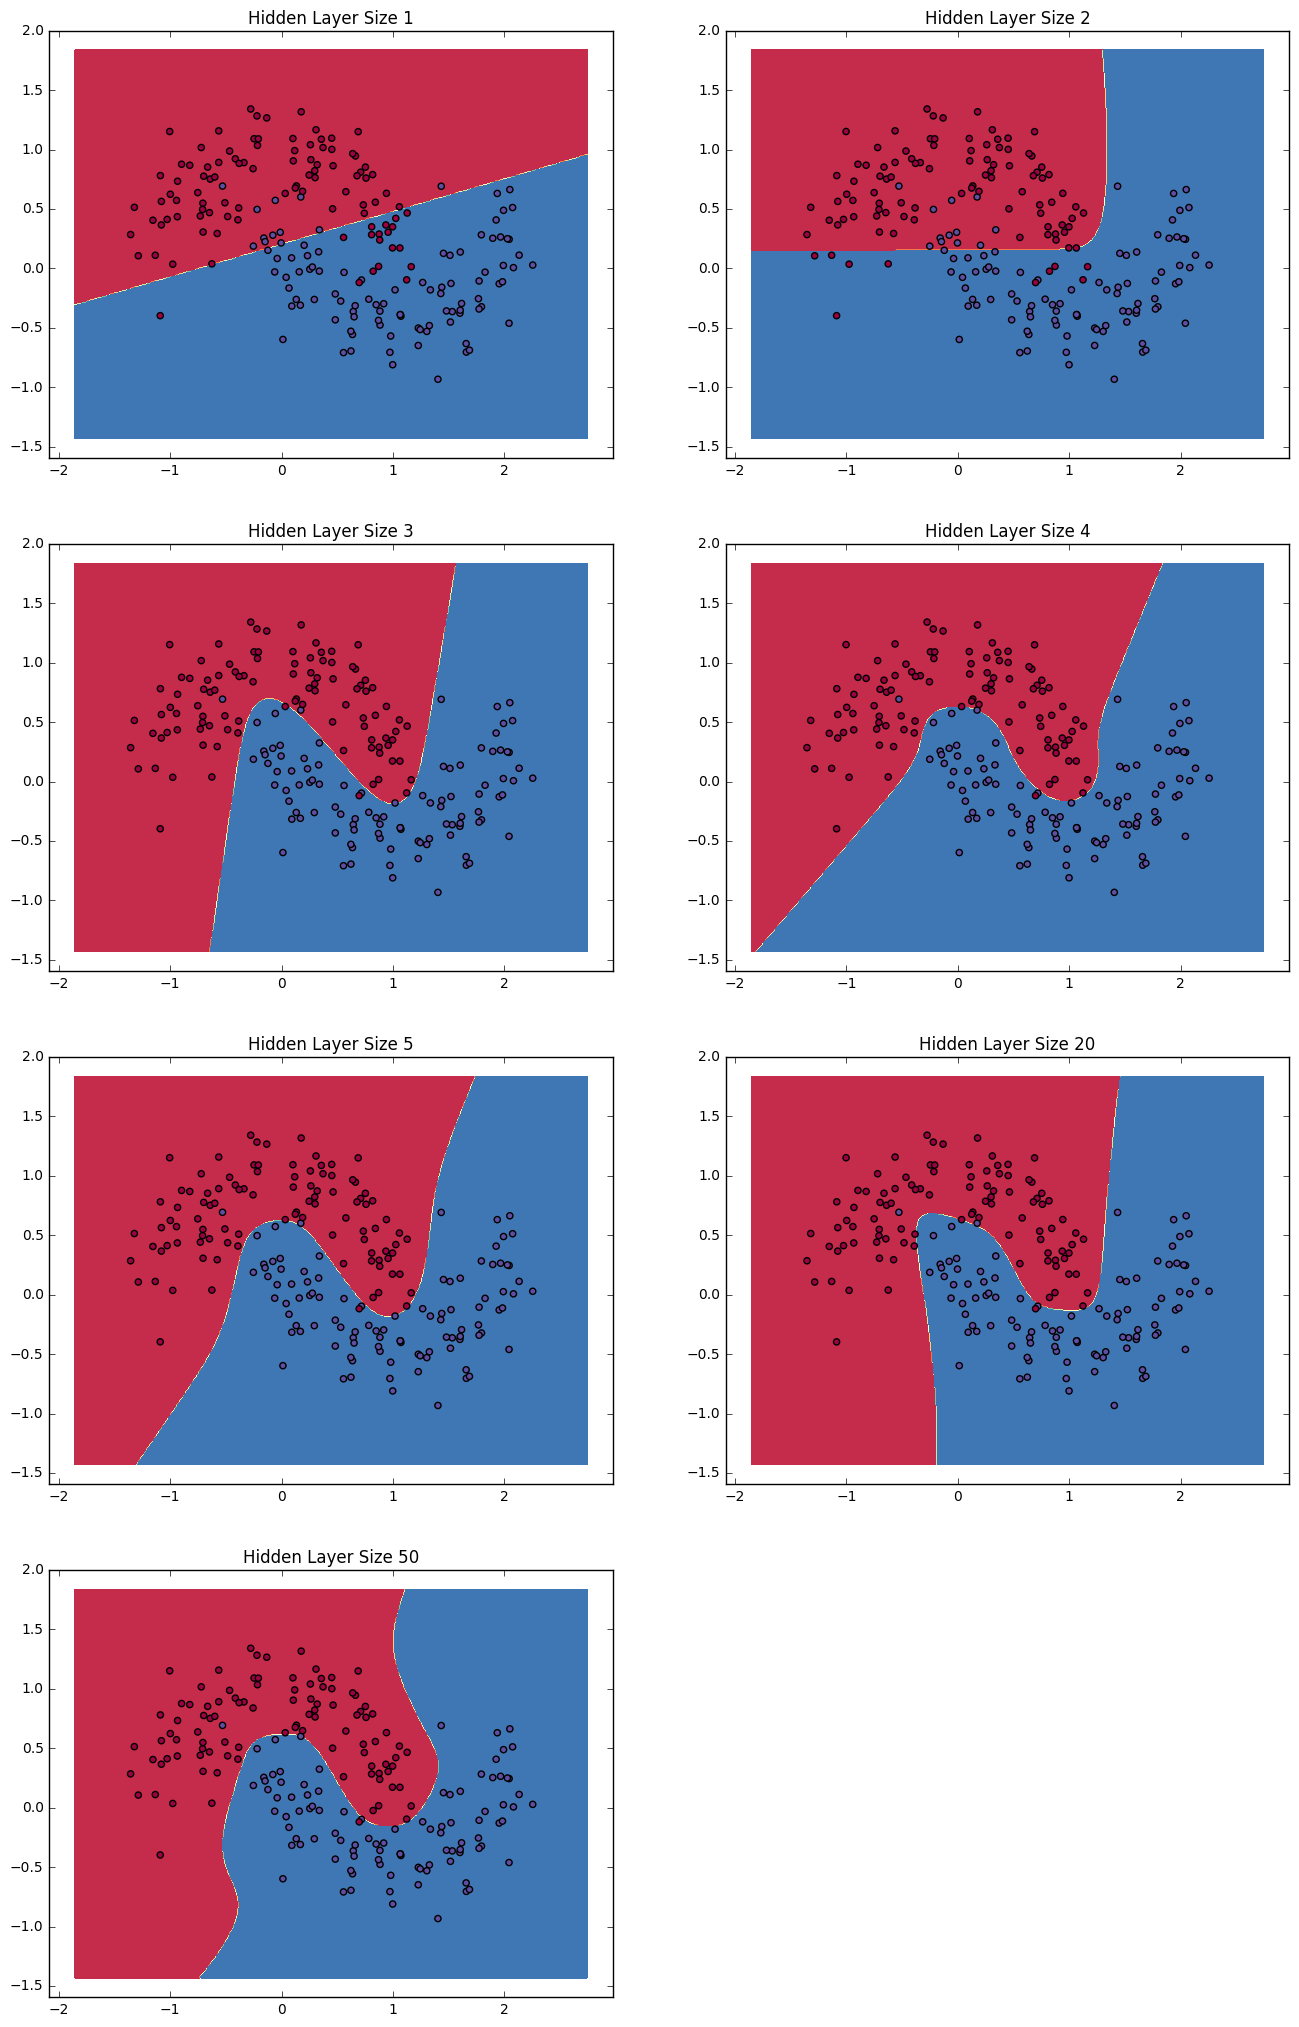

In [20]:
plt.figure (figsize=(16,32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate (hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title("Hidden Layer Size %d" % nn_hdim)
    model = build_model (nn_hdim, mini_batch=True)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show ()